In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import floor

In [2]:
df = pd.read_csv('chess.data')
pd.set_option('display.max_columns', df.shape[1])
df.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,C
0,f,f,f,f,f,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,t,f,t,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,t,f,f,f,l,f,n,f,f,t,f,f,f,t,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,t,f,t,f,f,f,f,f,f,f,t,t,n,won


In [3]:
df.describe()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,C
count,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196,3196
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,f,f,f,f,f,f,f,f,f,f,f,f,l,f,n,f,f,t,f,f,f,f,f,f,f,t,f,f,f,f,f,f,f,t,t,n,won
freq,2839,2971,3076,2874,2129,1722,2026,2500,1980,2225,1817,2860,2205,3181,2526,3040,3099,2196,3170,2714,2612,2556,3013,1975,3185,2216,3021,3195,3149,3060,2631,3021,1984,2007,2345,2407,1669


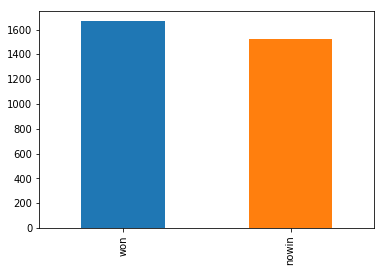

In [4]:
df['C'].value_counts().plot(kind='bar')

In [5]:
def calculate_N(df):
    N = []
    keys = list(df.keys())
    attr = list(df.keys())[:-1]

    for i in attr:
        N.append(dict(df[i].value_counts()))
        
    return N

In [6]:
N = calculate_N(df)

In [7]:
def calculate_NC(df):
    NC = {}
    keys = list(df.keys())
    attr = keys[:-1]
    classes = keys[-1]
    
    for k in df[classes].unique():
        NC[k] = []
        for a in attr:
            count = dict(df[a].where(df[classes] == k).value_counts())
            NC[k].append(count)
        
    return NC

In [8]:
NC = calculate_NC(df)

In [9]:
def vdm_distance(x1, x2):
    vdm = []
    q = 1

    for i in range(len(x1)):
        N1 = N[i][x1[i]]
        N2 = N[i][x2[i]]
        res = 0
        for k in NC.keys():
            if (x1[i] in NC[k][i]):
                NC1 = NC[k][i][x1[i]]
            if (x2[i] in NC[k][i]):
                NC2 = NC[k][i][x2[i]]
            res += (abs((NC1 / N1) - (NC2 / N2)) ** q)
        vdm.append(res)
        
    vdm = np.asarray(vdm)
    return np.sqrt(vdm.sum())
    

In [10]:
# vdm_distance([1, 2, 3, 4, 5], [1, 2, 3, 4, 5], N, NC)

In [11]:
def nn(x_train, y_train, xq):
    distances = []
    
    for i, x in enumerate(x_train):
        d = vdm_distance(x, xq)
        distances.append([d, y_train[i]])
        
    sorted_distances = sorted(distances, key=lambda z:z[0])
    neighbors = np.asarray(sorted_distances)
    
    return neighbors

In [12]:
def knn(x_train, y_train, xq, k):
    pred = []
    
    neighbors = nn(x_train, y_train, xq)
    freq = np.unique(neighbors[:k,-1], return_counts=True)
    pred.append(freq[0][freq[1].argmax()])
        
    return pred

In [13]:
def weighted_knn(x_train, y_train, xq, k):
    classes = {}
    weights = []
    distances = nn(x_train, y_train, xq)
    neighbors = distances[:k, :]
    for n in neighbors:
        if (float(n[0]) != 0):
            weights.append([1/float(n[0]),n[1]])
        else:
            weights.append([999999999,n[1]])
    for w in weights:
        if (w[-1] in classes):
            classes[w[-1]] += w[0]
        else:
            classes[w[-1]] = w[0]
            
    return max(classes, key=classes.get)

In [14]:
def cross_validation(data, n_fold, k, with_weight=False):
    size = data.shape[0]
    k_size = int(size / n_fold)
    x = [data[i:i+k_size,:-1] for i in range(0, size, k_size)]
    y = [data[i:i+k_size,-1] for i in range(0, size, k_size)]
    acc = []
    
    for i in range(n_fold):
        preds = []
        x_train = np.asarray(x[:i] + x[i+1:])
        y_train = np.asarray(y[:i] + y[i+1:])
        x_train = np.reshape(x_train, (size-k_size,-1))
        y_train = np.reshape(y_train, size-k_size)
        x_test = np.asarray(x[i])
        y_test = np.asarray(y[i])
        if (with_weight == True):
            for i, xq in enumerate(x_test):
                preds.append(weighted_knn(x_train, y_train, xq, k))
        else:
            for i, xq in enumerate(x_test):
                preds.append(knn(x_train, y_train, xq, k))
        
        preds = np.asarray(preds)
        preds = np.reshape(preds, k_size)
        acc.append(100*float((preds == y_test).sum()) / preds.shape[0])
    
    acc = np.asarray(acc)
    return acc.sum() / acc.shape[0]

In [15]:
n_fold = 10
data = df.values
np.random.shuffle(data)
mod = data.shape[0] % n_fold
data = data[mod:]
print(data.shape)

k_values = [1,2,3,5,7,9,11,13,15]
accs = []
weighted_accs = []

for k in k_values:
    if (k == 7):
        acc = cross_validation(data, 10, k)
        accs.append(acc)
        print("The accuracy for k = {:d} is: {:.2f}%".format(k, acc))

(3190, 37)
The accuracy for k = 7 is: 96.49%
